**About** : This notebook is used to prepare the data.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
cd ../src/

/workspace/kaggle_rsna_abdominal/src


## Initialization

### Imports

In [3]:
import os
import sys
import cv2
import glob
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from sklearn.linear_model import *

pd.set_option('display.width', 500)
pd.set_option('max_colwidth', 100)

## Data

### Imgs

In [52]:
files = os.listdir('../input/imgs/')

In [53]:
df = pd.DataFrame(files)
df.columns = ['file']

In [54]:
df['patient'] = df['file'].apply(lambda x: x.split('_')[0])
df['series'] = df['file'].apply(lambda x: x.split('_')[1])
df['frame'] = df['file'].apply(lambda x: x.split('_')[2][:-4])

df['path'] = '../input/imgs/' + df['file']

### Tags

In [7]:
tags = pd.read_parquet("../input/train_dicom_tags.parquet")

In [8]:
tags['z'] = tags['ImagePositionPatient'].apply(lambda x: float(x[:-1].split(', ')[-1]))

In [9]:
tags = tags[["path", "z"]].copy()

In [10]:
tags['patient'] = tags['path'].apply(lambda x: x.split('/')[1])
tags['series'] = tags['path'].apply(lambda x: x.split('/')[2])
tags['instance'] = tags['path'].apply(lambda x: x.split('/')[3][:-4])

In [11]:
tags = tags.sort_values(['patient', 'series', 'z'], ignore_index=True)

In [12]:
tags['frame'] = tags.groupby(['patient', 'series']).agg('rank')['z'].astype(int)
tags['frame'] -= 1

In [13]:
tags['frame'] = tags['frame'].apply(lambda x: f'{x:04d}')

In [14]:
tags.to_csv('../input/frame_mapping.csv', index=False)

In [15]:
tags.head()

,path,z,patient,series,instance,frame
0,train_images/10004/21057/1192.dcm,-1696.9,10004,21057,1192,0000
1,train_images/10004/21057/1191.dcm,-1696.4,10004,21057,1191,0001
2,train_images/10004/21057/1190.dcm,-1695.9,10004,21057,1190,0002
3,train_images/10004/21057/1189.dcm,-1695.4,10004,21057,1189,0003
4,train_images/10004/21057/1188.dcm,-1694.9,10004,21057,1188,0004


### Merge

In [55]:
df = df.merge(tags[['patient', 'series', 'frame', 'instance']], how="left")
df = df.sort_values(['patient', 'series', 'frame'], ignore_index=True)

In [56]:
df.isna().sum()

file        0
patient     0
series      0
frame       0
path        0
instance    0
dtype: int64

In [57]:
df.head()

,file,patient,series,frame,path,instance
0,10004_21057_0000.png,10004,21057,0000,../input/imgs/10004_21057_0000.png,1192
1,10004_21057_0001.png,10004,21057,0001,../input/imgs/10004_21057_0001.png,1191
2,10004_21057_0002.png,10004,21057,0002,../input/imgs/10004_21057_0002.png,1190
3,10004_21057_0003.png,10004,21057,0003,../input/imgs/10004_21057_0003.png,1189
4,10004_21057_0004.png,10004,21057,0004,../input/imgs/10004_21057_0004.png,1188


In [58]:
image_level = pd.read_csv('../input/image_level_labels.csv')

In [59]:
image_level.columns = ['patient', 'series', 'instance', 'injury_name']
image_level[image_level.columns] = image_level[image_level.columns].astype(str)

In [60]:
image_level = image_level.groupby(['patient', 'series', 'instance']).agg(list).reset_index()

In [61]:
image_level.head(1)

,patient,series,instance,injury_name
0,10004,21057,362,[Active_Extravasation]


In [62]:
dfm = df.merge(image_level, on=['patient', 'series', 'instance'], how="left")

In [63]:
dfm["injury_name"] = dfm["injury_name"].fillna('').astype(str)
dfm["extravasion_injury"] = dfm["injury_name"].apply(lambda x: "Active_Extravasation" in x).astype(np.uint8)
dfm["bowel_injury"] = dfm["injury_name"].apply(lambda x: "Bowel" in x).astype(np.uint8)

In [64]:
dfm = dfm[['patient', 'series', 'instance', "frame", 'extravasion_injury', 'bowel_injury', 'path']]
dfm.to_csv('../input/df_images_train.csv', index=False)

In [65]:
dfm.head()

,patient,series,instance,frame,extravasion_injury,bowel_injury,path
0,10004,21057,1192,0000,0,0,../input/imgs/10004_21057_0000.png
1,10004,21057,1191,0001,0,0,../input/imgs/10004_21057_0001.png
2,10004,21057,1190,0002,0,0,../input/imgs/10004_21057_0002.png
3,10004,21057,1189,0003,0,0,../input/imgs/10004_21057_0003.png
4,10004,21057,1188,0004,0,0,../input/imgs/10004_21057_0004.png


### Target EDA

In [68]:
train = pd.read_csv('../input/train.csv')

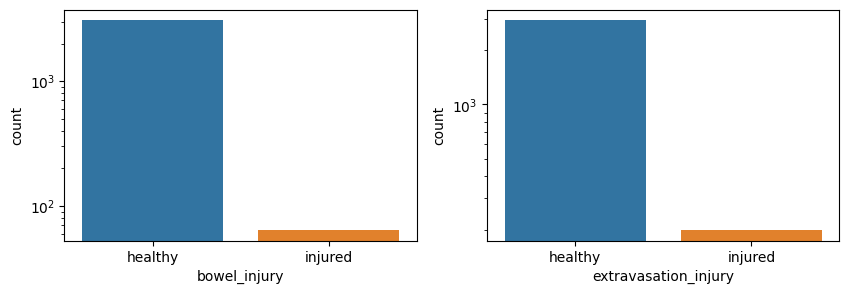

In [69]:
plt.figure(figsize=(10, 3))

for i, k in enumerate(['bowel_injury', 'extravasation_injury']):
    plt.subplot(1, 2, i + 1)
    sns.countplot(x=train[k])
    plt.yscale('log')
    plt.xticks([0, 1], ['healthy', 'injured'])
    
plt.show()

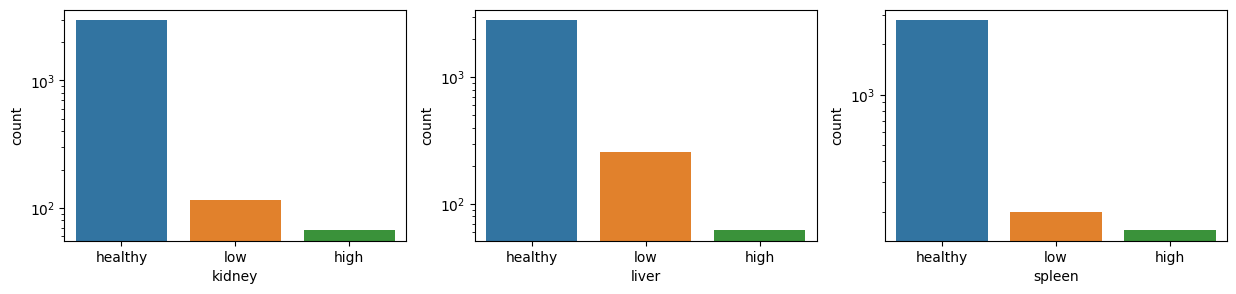

In [70]:
plt.figure(figsize=(15, 3))

for i, k in enumerate(['kidney', 'liver', 'spleen']):
    plt.subplot(1, 3, i + 1)
    train[k] = train[f'{k}_low'] + 2 * train[f'{k}_high']
    sns.countplot(x=train[k])
    plt.yscale('log')
    plt.xticks([0, 1, 2], ['healthy', 'low','high'])
    
plt.show()

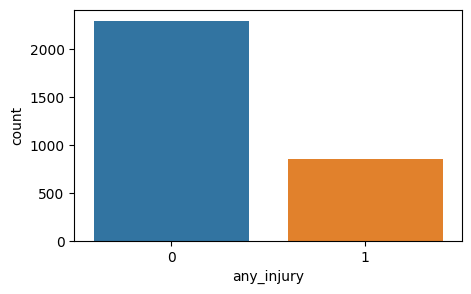

In [71]:
healthy = (
    (train['kidney'] == 0) &
    (train['liver'] == 0) &
    (train['spleen'] == 0)&
    (train['bowel_injury'] == 0) &
    (train['extravasation_injury'] == 0)
)

(train['any_injury'] == ~healthy).all()

plt.figure(figsize=(5, 3))
sns.countplot(x=train['any_injury'])
plt.show()

In [ ]:
def get_weight(row):
    

In [73]:
tgts = ['kidney', 'liver', 'spleen', 'bowel_injury', 'extravasation_injury']

for i, t1 in enumerate(tgts):
    for t2 in tgts[i + 1:]:
        print(
            f'{t1.split("_")[0][:6]}\t:', (train[t1] > 0).sum(),
            f' \t{t2.split("_")[0][:6]}\t:', (train[t2] > 0).sum(),
            f' \t{t1.split("_")[0][:6]} & {t2.split("_")[0][:6]}\t:', ((train[t1] > 0) & (train[t2] > 0)).sum()
        )

kidney	: 182  	liver	: 321  	kidney & liver	: 54
kidney	: 182  	spleen	: 354  	kidney & spleen	: 49
kidney	: 182  	bowel	: 64  	kidney & bowel	: 6
kidney	: 182  	extrav	: 200  	kidney & extrav	: 30
liver	: 321  	spleen	: 354  	liver & spleen	: 51
liver	: 321  	bowel	: 64  	liver & bowel	: 14
liver	: 321  	extrav	: 200  	liver & extrav	: 35
spleen	: 354  	bowel	: 64  	spleen & bowel	: 16
spleen	: 354  	extrav	: 200  	spleen & extrav	: 54
bowel	: 64  	extrav	: 200  	bowel & extrav	: 18


### Metric

In [ ]:
from sklearn.metrics import log_loss
from util.metrics import *

In [86]:
log_loss([2, 0, 0, 1], [[.1, 0, .9], [.9, .1, 0], [.8, .2, 0], [.35, .65, 0]])

0.2161618746805802

In [127]:
from sklearn.metrics import log_loss
log_loss([0, 0, 0, 1], [[1, 0,], [.9, .1], [.8, .2], [.35, .65]], labels=[0, 1])

0.18982174576612282

In [128]:
from sklearn.metrics import log_loss
log_loss([0, 0, 0, 1], [0, .1, .2, .65], labels=[0, 1])

0.18982174576612282

In [87]:
from sklearn.metrics import log_loss
log_loss([[0, 0, 1], [1, 0, 0], [1, 0, 0], [0, 1, 0]],  [[.1, 0, .9], [.9, .1, 0], [.8, .2, 0], [.35, .65, 0]])

0.2161618746805802

In [182]:
preds = [
    np.random.random((5, 1)),
    np.random.random((5, 1)),
    np.random.random((5, 3)),
    np.random.random((5, 3)),
    np.random.random((5, 3)),
]

In [183]:
preds

[array([[0.1839206 ],
        [0.15849095],
        [0.35450787],
        [0.02094858],
        [0.03845498]]),
 array([[0.63976284],
        [0.20222225],
        [0.1310889 ],
        [0.34451755],
        [0.3303782 ]]),
 array([[0.17956545, 0.75641634, 0.24437571],
        [0.67571978, 0.71154955, 0.73402959],
        [0.05668619, 0.20940846, 0.15223877],
        [0.42769885, 0.71156276, 0.1090004 ],
        [0.9194253 , 0.22843592, 0.70444659]]),
 array([[0.92526758, 0.11902403, 0.52146179],
        [0.57845164, 0.22057624, 0.64371981],
        [0.51325374, 0.98277184, 0.05446573],
        [0.85984291, 0.12770118, 0.48966621],
        [0.97790523, 0.12121223, 0.06493877]]),
 array([[0.0205382 , 0.71524817, 0.994042  ],
        [0.74795046, 0.62333807, 0.15875775],
        [0.11292268, 0.7182199 , 0.90917463],
        [0.3605609 , 0.60939429, 0.9907376 ],
        [0.40584262, 0.35236852, 0.6961993 ]])]

In [184]:
losses, avg_loss = rsna_loss(preds, train.head(5))

bowel_injury [1 1 1 1 1]
extravasation_injury [6 1 1 1 1]
kidney [2 1 1 1 1]
liver [1 1 1 1 1]
spleen [4 1 1 1 2]
any_injury [6 1 1 1 6]


In [176]:
losses, avg_loss

({'bowel_injury': 0.9425557217605599,
  'extravasation_injury': 0.9610389494264533,
  'kidney': 0.9845646318826592,
  'liver': 1.8673662693143023,
  'spleen': 1.3114247026374282,
  'any_injury': 0.5932454769311845},
 1.1100326253254311)

In [ ]:
train.to_csv('../input/df_train.csv', index=False)

In [ ]:
train.head()

Done ! 